Berhasil memuat file: 01_02_2025-24_05_2025.csv
Jumlah baris data awal: 917

Jumlah baris setelah pembersihan dan filter (hanya trade buy/sell): 917
--- HASIL ANALISIS PERFORMA TRADING ---
Tanggal Analisis           : 2025-05-24 05:49:45
File Data                  : 01_02_2025-24_05_2025.csv
Ekuitas Awal Manual        : 600,000.00 IDR
Ekuitas Akhir (Dihitung)   : 9,990,127.78 IDR
--------------------------------------------------
Total Jumlah Trade         : 917
Jumlah Trade yang Profit   : 401
Jumlah Trade yang Loss     : 516
Win Rate                   : 43.73%
--------------------------------------------------
Total Pips yang Didapatkan : 2170.66 pips
  Rata-rata Pips Profit    : 38.97 pips
  Rata-rata Pips Rugi      : 26.07 pips
--------------------------------------------------
Total Profit (kolom 'profit_idr') : 9,390,127.78 (IDR)
  Rata-rata Profit %% Equity : 4.49%
  Rata-rata Rugi %% Equity   : 2.99%
Growth Selama Periode      : 1565.02%
Max Drawdown               : 125.68%
Max

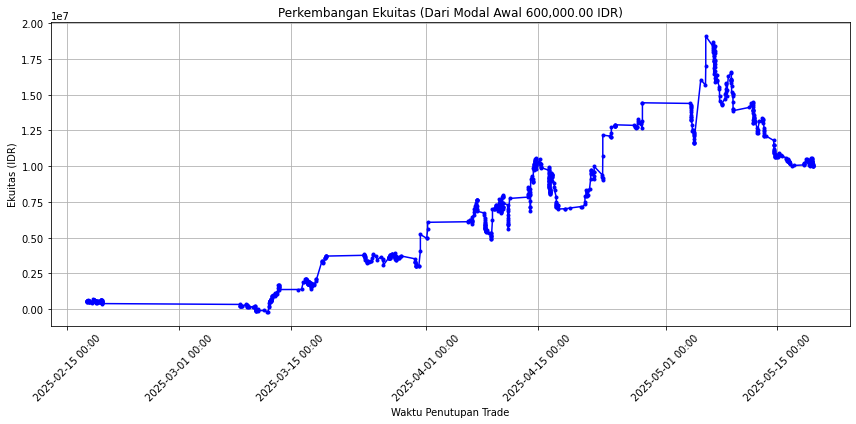


--------------------------------------------------
--- STATUS PENYIMPANAN FILE ANALISIS ---
Semua file hasil analisis berhasil disimpan di folder:
result/2025-05-24/01_02_2025-24_05_2025
--------------------------------------------------


In [19]:
import pandas as pd
import os
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- KONFIGURASI ---
NAMA_FILE_CSV_INPUT = "01_02_2025-24_05_2025.csv"
NAMA_DASAR_FILE_CSV_OUTPUT = "hasil_analisis_trade_lengkap.csv"
NAMA_DASAR_FILE_EQUITY_CURVE = "equity_curve.png"
NAMA_DASAR_FILE_REPORT_TEKS_SUFFIX = "_post_trade_analysis.txt"

ACCOUNT_CURRENCY_LABEL = "IDR"
MANUAL_INITIAL_ACCOUNT_CURRENCY_EQUITY = 600000.00

ANNUAL_RISK_FREE_RATE = 0.02
TRADING_DAYS_PER_YEAR = 252.0

# --- FUNGSI ---
def identifikasi_nama_kolom(daftar_alias, peta_kolom_aktual):
    for alias in daftar_alias:
        if alias in peta_kolom_aktual: return peta_kolom_aktual[alias]
    return None

def hitung_streaks(seri_profit):
    max_win_streak, current_win_streak, max_loss_streak, current_loss_streak = 0,0,0,0
    for profit in seri_profit:
        if profit > 0: current_win_streak += 1; current_loss_streak = 0
        elif profit < 0: current_loss_streak += 1; current_win_streak = 0
        else: current_win_streak, current_loss_streak = 0,0
        if current_win_streak > max_win_streak: max_win_streak = current_win_streak
        if current_loss_streak > max_loss_streak: max_loss_streak = current_loss_streak
    return max_win_streak, max_loss_streak

# --- FUNGSI UTAMA ANALISIS ---
def analisis_performa_trading(nama_file_input_asli, 
                              nama_dasar_csv_output, 
                              nama_dasar_equity_curve, 
                              nama_dasar_report_teks_suffix, 
                              initial_equity_account_currency,
                              currency_label,
                              annual_rfr,
                              trading_days_year
                              ):
    # Inisialisasi status penyimpanan
    text_report_saved = False
    equity_curve_saved = False # Akan di-set True jika grafik dibuat dan disimpan
    detailed_csv_saved = False # Akan di-set True jika CSV detail disimpan
    
    try:
        tanggal_analisis_dibuat_obj = datetime.now()
        tanggal_analisis_dibuat_str_ymd = tanggal_analisis_dibuat_obj.strftime("%Y-%m-%d")
        tanggal_dan_waktu_analisis_str = tanggal_analisis_dibuat_obj.strftime("%Y-%m-%d %H:%M:%S")
        nama_file_input_basename = os.path.basename(nama_file_input_asli)
        nama_file_input_tanpa_ekstensi = os.path.splitext(nama_file_input_basename)[0]
        folder_result_utama = "result"; folder_output_spesifik_tanggal = os.path.join(folder_result_utama, tanggal_analisis_dibuat_str_ymd)
        folder_output_final = os.path.join(folder_output_spesifik_tanggal, nama_file_input_tanpa_ekstensi)
        os.makedirs(folder_output_final, exist_ok=True)
        # Menghilangkan print INFO folder output:
        # print(f"INFO: File output akan disimpan di folder: {folder_output_final}") 
        path_lengkap_csv_output = os.path.join(folder_output_final, nama_dasar_csv_output)
        path_lengkap_equity_curve = os.path.join(folder_output_final, nama_dasar_equity_curve)
        path_lengkap_report_teks = os.path.join(folder_output_final, f"{tanggal_analisis_dibuat_str_ymd}_{nama_file_input_tanpa_ekstensi}{nama_dasar_report_teks_suffix}")

        if not os.path.exists(nama_file_input_asli): return print(f"ERROR: File input '{nama_file_input_asli}' tidak ditemukan.")
        df = pd.read_csv(nama_file_input_asli); print(f"Berhasil memuat file: {nama_file_input_asli}"); print(f"Jumlah baris data awal: {len(df)}")

        peta_kolom_aktual = { col.lower().replace(' ', '').replace('_', '').replace('/', '').replace('.', ''): col for col in df.columns }
        profit_col_suffix = currency_label.lower(); alias_profit = [f'profit{profit_col_suffix}', 'profitusc', 'profit', 'pl', 'netprofit', 'pnl'] 
        alias_simbol = ['symbol']; alias_tipe = ['type']; alias_harga_buka = ['openingprice']; alias_harga_tutup = ['closingprice']
        alias_waktu_buka = ['openingtimeutc']; alias_waktu_tutup = ['closingtimeutc']; alias_close_reason = ['closereason']
        kolom_simbol = identifikasi_nama_kolom(alias_simbol, peta_kolom_aktual); kolom_tipe = identifikasi_nama_kolom(alias_tipe, peta_kolom_aktual)
        kolom_harga_buka = identifikasi_nama_kolom(alias_harga_buka, peta_kolom_aktual); kolom_harga_tutup = identifikasi_nama_kolom(alias_harga_tutup, peta_kolom_aktual)
        kolom_profit = identifikasi_nama_kolom(alias_profit, peta_kolom_aktual)
        kolom_waktu_buka = identifikasi_nama_kolom(alias_waktu_buka, peta_kolom_aktual); kolom_waktu_tutup = identifikasi_nama_kolom(alias_waktu_tutup, peta_kolom_aktual)
        kolom_close_reason = identifikasi_nama_kolom(alias_close_reason, peta_kolom_aktual)
        
        kolom_penting_dasar = {"Simbol": kolom_simbol, "Tipe Trade": kolom_tipe, "Harga Buka": kolom_harga_buka, "Harga Tutup": kolom_harga_tutup, "Profit": kolom_profit, "Waktu Tutup": kolom_waktu_tutup}
        kolom_tidak_ditemukan_dasar = [nama for nama, kolom in kolom_penting_dasar.items() if kolom is None]
        if kolom_tidak_ditemukan_dasar:
            print("\nERROR: Kolom dasar untuk analisis tidak teridentifikasi.")
            for nama in kolom_tidak_ditemukan_dasar: print(f"- Kolom '{nama}' tidak ditemukan (mencari suffix: {profit_col_suffix} untuk profit).")
            return

        hitung_holding_period = kolom_waktu_buka and kolom_waktu_tutup; hitung_intervention_rate = bool(kolom_close_reason); hitung_equity_analysis = bool(kolom_profit and kolom_waktu_tutup)

        df[kolom_harga_buka] = pd.to_numeric(df[kolom_harga_buka], errors='coerce'); df[kolom_harga_tutup] = pd.to_numeric(df[kolom_harga_tutup], errors='coerce')
        df[kolom_profit] = pd.to_numeric(df[kolom_profit], errors='coerce'); df[kolom_waktu_tutup] = pd.to_datetime(df[kolom_waktu_tutup], errors='coerce')
        kolom_untuk_dropna = [kolom_simbol, kolom_tipe, kolom_harga_buka, kolom_harga_tutup, kolom_profit, kolom_waktu_tutup]
        if hitung_holding_period:
             df[kolom_waktu_buka] = pd.to_datetime(df[kolom_waktu_buka], errors='coerce')
             if not df[kolom_waktu_buka].isnull().all(): kolom_untuk_dropna.append(kolom_waktu_buka)
             else: hitung_holding_period = False
        df.dropna(subset=kolom_untuk_dropna, inplace=True)
        if kolom_tipe in df.columns: df['TipeTradeStandar'] = df[kolom_tipe].apply(lambda x: 'buy' if x == 0 else ('sell' if x == 1 else str(x).lower().strip())) if df[kolom_tipe].dtype in ['int64', 'float64'] else df[kolom_tipe].astype(str).str.lower().str.strip()
        else: return print(f"ERROR: Kolom Tipe ('{kolom_tipe}') tidak ada.")
        trade_df = df[df['TipeTradeStandar'].isin(['buy', 'sell'])].copy()
        trade_df = trade_df.sort_values(by=kolom_waktu_tutup).reset_index(drop=True)
        print(f"\nJumlah baris setelah pembersihan dan filter (hanya trade buy/sell): {len(trade_df)}")
        if trade_df.empty: return print("Tidak ada data trade valid untuk dianalisis setelah semua filter.")
            
        if hitung_holding_period: trade_df.loc[:, 'DurasiHolding'] = trade_df[kolom_waktu_tutup] - trade_df[kolom_waktu_buka]; trade_df = trade_df[trade_df['DurasiHolding'] >= pd.Timedelta(seconds=0)].copy(); 
        else: trade_df.loc[:, 'DurasiHolding'] = pd.NaT
        if trade_df.empty and hitung_holding_period : hitung_holding_period = False

        trade_df.loc[:, 'Pips'] = 0.0
        for index, row in trade_df.iterrows():
            simbol_val = str(row[kolom_simbol]).upper(); harga_buka_val = row[kolom_harga_buka]; harga_tutup_val = row[kolom_harga_tutup]; tipe_trade_val = row['TipeTradeStandar']
            perbedaan_harga = harga_tutup_val - harga_buka_val; pips = 0.0
            if "BTCUSD" in simbol_val: faktor_pips = 0.1; pips = (perbedaan_harga * faktor_pips) if tipe_trade_val == 'buy' else (-perbedaan_harga * faktor_pips)
            elif "XAUUSD" in simbol_val: faktor_pips = 10.0; pips = (perbedaan_harga * faktor_pips) if tipe_trade_val == 'buy' else (-perbedaan_harga * faktor_pips)
            trade_df.loc[index, 'Pips'] = pips
        
        unit_perhitungan = currency_label; initial_equity_for_calc = initial_equity_account_currency
        trade_df.loc[:, f'ProfitKumulatif{unit_perhitungan}'] = trade_df[kolom_profit].cumsum()
        trade_df.loc[:, f'EquityCurve{unit_perhitungan}'] = initial_equity_for_calc + trade_df[f'ProfitKumulatif{unit_perhitungan}']
        trade_df.loc[:, f'EquitySebelumTrade{unit_perhitungan}'] = initial_equity_for_calc
        if len(trade_df) > 1: trade_df.loc[1:, f'EquitySebelumTrade{unit_perhitungan}'] = trade_df[f'EquityCurve{unit_perhitungan}'].iloc[:-1].values
        trade_df.loc[:, 'PnLPercentOfEquity'] = np.nan
        valid_equity_before_trade_mask = trade_df[f'EquitySebelumTrade{unit_perhitungan}'] > 0
        trade_df.loc[valid_equity_before_trade_mask, 'PnLPercentOfEquity'] = (trade_df.loc[valid_equity_before_trade_mask, kolom_profit] / trade_df.loc[valid_equity_before_trade_mask, f'EquitySebelumTrade{unit_perhitungan}']) * 100
        trade_df.loc[:, 'HoldingRange'] = pd.NA
        if hitung_holding_period and 'DurasiHolding' in trade_df.columns:
            valid_durations = trade_df['DurasiHolding'].dropna();
            if not valid_durations.empty:
                holding_periods_minutes = valid_durations.dt.total_seconds() / 60.0;
                if not holding_periods_minutes.empty:
                    bins_minutes = [-1, 1, 5, 15, 30, 60, 120, 240, 480, 1440, 2880, np.inf]; labels_minutes = ['<1 min', '1-5 min', '5-15 min', '15-30 min', '30-60 min', '1-2 jam', '2-4 jam', '4-8 jam', '8-24 jam', '1-2 hari', '>2 hari'];
                    binned_data = pd.cut(holding_periods_minutes, bins=bins_minutes, labels=labels_minutes, right=False);
                    if not binned_data.empty:
                        if not pd.api.types.is_categorical_dtype(trade_df['HoldingRange']): trade_df['HoldingRange'] = trade_df['HoldingRange'].astype('object')
                        trade_df['HoldingRange'].update(binned_data)
        if 'HoldingRange' in trade_df.columns: trade_df['HoldingRange'] = trade_df['HoldingRange'].fillna("N/A")

        jumlah_total_trade = len(trade_df);
        if jumlah_total_trade == 0: return print("Tidak ada trade tersisa untuk analisis.")
        winning_trades_df = trade_df[trade_df[kolom_profit] > 0]; losing_trades_df = trade_df[trade_df[kolom_profit] < 0]
        jumlah_trade_profit = len(winning_trades_df); jumlah_trade_loss = len(losing_trades_df)
        avg_pips_profit = winning_trades_df['Pips'].mean() if jumlah_trade_profit > 0 else 0.0
        avg_pips_loss = abs(losing_trades_df['Pips'].mean()) if jumlah_trade_loss > 0 else 0.0
        avg_profit_percent_equity = winning_trades_df['PnLPercentOfEquity'].mean() if jumlah_trade_profit > 0 else 0.0
        avg_loss_percent_equity = abs(losing_trades_df['PnLPercentOfEquity'].mean()) if jumlah_trade_loss > 0 else 0.0
        total_pips = trade_df['Pips'].sum(); total_profit_val_calc_unit = trade_df[kolom_profit].sum()
        win_rate = (jumlah_trade_profit / jumlah_total_trade) * 100 if jumlah_total_trade > 0 else 0.0
        max_consecutive_wins, max_consecutive_losses = hitung_streaks(trade_df[kolom_profit])
        
        sharpe_ratio_annualized, sortino_ratio_annualized = np.nan, np.nan
        if jumlah_total_trade > 1 and 'PnLPercentOfEquity' in trade_df.columns :
            returns_per_trade = trade_df['PnLPercentOfEquity'].dropna() / 100.0 
            if len(returns_per_trade) > 1 :
                trades_per_year_estimate = jumlah_total_trade
                if kolom_waktu_tutup in trade_df.columns and len(trade_df[kolom_waktu_tutup]) > 1:
                    first_trade_time = trade_df[kolom_waktu_tutup].min(); last_trade_time = trade_df[kolom_waktu_tutup].max()
                    duration_days = (last_trade_time - first_trade_time).total_seconds() / (24 * 60 * 60)
                    if duration_days < (1.0 / trading_days_year) : duration_days = 1.0 / trading_days_year
                    trades_per_year_estimate = (jumlah_total_trade / duration_days) * trading_days_year if duration_days > 0 else jumlah_total_trade * trading_days_year
                
                mean_return_annual = returns_per_trade.mean() * trades_per_year_estimate
                std_dev_annual = returns_per_trade.std() * np.sqrt(trades_per_year_estimate)
                if std_dev_annual != 0 and not np.isnan(std_dev_annual): sharpe_ratio_annualized = (mean_return_annual - annual_rfr) / std_dev_annual
                
                target_return_annual_for_sortino = annual_rfr 
                annualized_trade_returns = returns_per_trade * trades_per_year_estimate
                downside_returns_for_sortino = annualized_trade_returns[annualized_trade_returns < target_return_annual_for_sortino]
                if not downside_returns_for_sortino.empty:
                    downside_deviation_annual = np.sqrt(np.mean((downside_returns_for_sortino - target_return_annual_for_sortino)**2))
                    if downside_deviation_annual != 0 and not np.isnan(downside_deviation_annual): sortino_ratio_annualized = (mean_return_annual - target_return_annual_for_sortino) / downside_deviation_annual
                elif mean_return_annual > target_return_annual_for_sortino : sortino_ratio_annualized = np.inf
        
        growth_percent_str = "N/A"; max_drawdown_percentage = 0.0; max_consecutive_profit_percent = 0.0
        equity_curve_for_plot = None; unit_display_ekuitas = "USD" if unit_perhitungan == "USC" else unit_perhitungan
        initial_equity_for_display_calc = initial_equity_account_currency; final_equity_for_display = initial_equity_account_currency
        if unit_perhitungan == "USC" and unit_display_ekuitas == "USD": initial_equity_for_display_calc = initial_equity_account_currency / 100.0

        if hitung_equity_analysis and not trade_df.empty and f'EquityCurve{unit_perhitungan}' in trade_df.columns:
            equity_curve_calc_unit = trade_df[f'EquityCurve{unit_perhitungan}']
            equity_points_for_drawdown = pd.concat([pd.Series([initial_equity_for_calc]), equity_curve_calc_unit], ignore_index=True)
            peak_equity_series = equity_points_for_drawdown.expanding(min_periods=1).max()
            drawdown_series = equity_points_for_drawdown - peak_equity_series
            drawdown_percent_series = (drawdown_series / peak_equity_series.replace(0, np.nan)) * 100 
            max_drawdown_percentage = abs(drawdown_percent_series.min()) if not drawdown_percent_series.empty else 0.0
            current_streak_profit_calc_unit, equity_at_streak_start_calc_unit, is_in_win_streak_calc_unit = 0,0,False
            for index, row in trade_df.iterrows():
                profit_trade, equity_before_this_trade = row[kolom_profit], row[f'EquitySebelumTrade{unit_perhitungan}']
                if profit_trade > 0:
                    if not is_in_win_streak_calc_unit: is_in_win_streak_calc_unit, equity_at_streak_start_calc_unit, current_streak_profit_calc_unit = True, equity_before_this_trade, profit_trade
                    else: current_streak_profit_calc_unit += profit_trade
                else:
                    if is_in_win_streak_calc_unit:
                        if equity_at_streak_start_calc_unit > 0: streak_profit_percent = (current_streak_profit_calc_unit / equity_at_streak_start_calc_unit) * 100
                        if streak_profit_percent > max_consecutive_profit_percent: max_consecutive_profit_percent = streak_profit_percent
                        is_in_win_streak_calc_unit, current_streak_profit_calc_unit = False,0
            if is_in_win_streak_calc_unit and equity_at_streak_start_calc_unit > 0:
                streak_profit_percent = (current_streak_profit_calc_unit / equity_at_streak_start_calc_unit) * 100
                if streak_profit_percent > max_consecutive_profit_percent: max_consecutive_profit_percent = streak_profit_percent
            
            final_calculated_equity_calc_unit = trade_df[f'EquityCurve{unit_perhitungan}'].iloc[-1]
            final_equity_for_display = final_calculated_equity_calc_unit
            if unit_perhitungan == "USC" and unit_display_ekuitas == "USD": final_equity_for_display = final_calculated_equity_calc_unit / 100.0

            if initial_equity_for_calc != 0: growth_percent = ((final_calculated_equity_calc_unit - initial_equity_for_calc) / abs(initial_equity_for_calc)) * 100; growth_percent_str = f"{growth_percent:.2f}%"
            elif final_calculated_equity_calc_unit > 0 : growth_percent_str = "Inf (dari 0)"
            else: growth_percent_str = "0.00% (atau tidak terdefinisi)"
            
            if unit_perhitungan == "USC" and unit_display_ekuitas == "USD": equity_curve_for_plot = equity_curve_calc_unit / 100.0
            else: equity_curve_for_plot = equity_curve_calc_unit
        
        avg_holding_period_str, median_holding_period_str, most_common_holding_range_str = "N/A", "N/A", "N/A"
        if hitung_holding_period and 'DurasiHolding' in trade_df.columns:
            valid_holding_periods = trade_df['DurasiHolding'].dropna();
            if not valid_holding_periods.empty:
                avg_hp = valid_holding_periods.mean(); total_seconds_avg = avg_hp.total_seconds(); d_avg, h_avg, m_avg, s_avg = int(total_seconds_avg // 86400), int((total_seconds_avg % 86400) // 3600), int((total_seconds_avg % 3600) // 60), int(total_seconds_avg % 60); avg_holding_period_str = f"{d_avg} hari, {h_avg} jam, {m_avg} menit, {s_avg} detik"
                median_hp = valid_holding_periods.median(); total_seconds_med = median_hp.total_seconds(); d_med, h_med, m_med, s_med = int(total_seconds_med // 86400), int((total_seconds_med % 86400) // 3600), int((total_seconds_med % 3600) // 60), int(total_seconds_med % 60); median_holding_period_str = f"{d_med} hari, {h_med} jam, {m_med} menit, {s_med} detik"
                if 'HoldingRange' in trade_df.columns:
                    valid_ranges = trade_df.loc[trade_df['HoldingRange'] != "N/A", 'HoldingRange'].dropna();
                    if not valid_ranges.empty: mode_series = valid_ranges.mode();
                    if not mode_series.empty: most_common_holding_range_str = mode_series[0]

        intervention_rate_str = "N/A"
        if hitung_intervention_rate and kolom_close_reason in trade_df.columns:
            valid_close_reasons = trade_df[kolom_close_reason].dropna();
            if not valid_close_reasons.empty and jumlah_total_trade > 0:
                intervensi_pengguna = valid_close_reasons.astype(str).str.lower().str.strip() == 'user'; jumlah_intervensi = intervensi_pengguna.sum();
                intervention_rate = (jumlah_intervensi / jumlah_total_trade) * 100; intervention_rate_str = f"{intervention_rate:.2f}% ({jumlah_intervensi} dari {jumlah_total_trade} trade)"

        hasil_analisis_lines = []; hasil_analisis_lines.append("--- HASIL ANALISIS PERFORMA TRADING ---")
        hasil_analisis_lines.append(f"Tanggal Analisis           : {tanggal_dan_waktu_analisis_str}"); hasil_analisis_lines.append(f"File Data                  : {nama_file_input_basename}"); 
        hasil_analisis_lines.append(f"Ekuitas Awal Manual        : {initial_equity_for_display_calc:,.2f} {unit_display_ekuitas}")
        if hitung_equity_analysis and not trade_df.empty :
             hasil_analisis_lines.append(f"Ekuitas Akhir (Dihitung)   : {final_equity_for_display:,.2f} {unit_display_ekuitas}")
        hasil_analisis_lines.append("-" * 50); hasil_analisis_lines.append(f"Total Jumlah Trade         : {jumlah_total_trade}"); hasil_analisis_lines.append(f"Jumlah Trade yang Profit   : {jumlah_trade_profit}"); hasil_analisis_lines.append(f"Jumlah Trade yang Loss     : {jumlah_trade_loss}"); hasil_analisis_lines.append(f"Win Rate                   : {win_rate:.2f}%"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Total Pips yang Didapatkan : {total_pips:.2f} pips"); hasil_analisis_lines.append(f"  Rata-rata Pips Profit    : {avg_pips_profit:.2f} pips"); hasil_analisis_lines.append(f"  Rata-rata Pips Rugi      : {avg_pips_loss:.2f} pips"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Total Profit (kolom '{kolom_profit}') : {total_profit_val_calc_unit:,.2f} ({unit_perhitungan})"); hasil_analisis_lines.append(f"  Rata-rata Profit %% Equity : {avg_profit_percent_equity:.2f}%"); hasil_analisis_lines.append(f"  Rata-rata Rugi %% Equity   : {avg_loss_percent_equity:.2f}%"); hasil_analisis_lines.append(f"Growth Selama Periode      : {growth_percent_str}"); hasil_analisis_lines.append(f"Max Drawdown               : {max_drawdown_percentage:.2f}%") ; hasil_analisis_lines.append(f"Max Consecutive Profit %%  : {max_consecutive_profit_percent:.2f}%"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Sharpe Ratio (Annualized)  : {sharpe_ratio_annualized:.2f} (RFR: {annual_rfr*100:.1f}%)"); hasil_analisis_lines.append(f"Sortino Ratio (Annualized) : {sortino_ratio_annualized:.2f} (MAR: {annual_rfr*100:.1f}%)"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Max Consecutive Wins       : {max_consecutive_wins} trade"); hasil_analisis_lines.append(f"Max Consecutive Losses     : {max_consecutive_losses} trade"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Rata-rata Holding Period   : {avg_holding_period_str}"); hasil_analisis_lines.append(f"Median Holding Period      : {median_holding_period_str}"); hasil_analisis_lines.append(f"Rentang Holding Umum       : {most_common_holding_range_str}"); hasil_analisis_lines.append("-" * 50)
        hasil_analisis_lines.append(f"Intervention Rate (by User): {intervention_rate_str}")
        summary_string = "\n".join(hasil_analisis_lines); print(summary_string)
        
        # Simpan laporan teks
        try:
            with open(path_lengkap_report_teks, 'w') as f: f.write(summary_string)
            text_report_saved = True # Set flag
        except Exception as e_save_txt: print(f"ERROR saat menyimpan file report teks: {e_save_txt}")

        # Tampilkan dan Simpan Grafik Equity Curve
        grafik_dibuat_dan_disimpan = False
        if hitung_equity_analysis and not trade_df.empty and equity_curve_for_plot is not None:
            plt.figure(figsize=(12,6)); plt.plot(trade_df[kolom_waktu_tutup], equity_curve_for_plot, linestyle='-', color='b', marker='o', markersize=3)
            plt.title(f'Perkembangan Ekuitas (Dari Modal Awal {initial_equity_for_display_calc:,.2f} {unit_display_ekuitas})'); plt.xlabel('Waktu Penutupan Trade'); plt.ylabel(f'Ekuitas ({unit_display_ekuitas})')
            plt.grid(True); plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M')); plt.xticks(rotation=45); plt.tight_layout()
            try:
                plt.savefig(path_lengkap_equity_curve)
                equity_curve_saved = True # Set flag
            except Exception as e_plot: print(f"ERROR saat menyimpan grafik: {e_plot}")
            plt.show(); plt.close()
            grafik_dibuat_dan_disimpan = equity_curve_saved # Jika dibuat, statusnya tergantung savefig
        
        # Simpan Trade Lengkap ke CSV Baru
        csv_detail_disimpan = False
        try:
            kolom_tambahan_dihasilkan = ['TipeTradeStandar', 'Pips', 'DurasiHolding', 'HoldingRange', f'ProfitKumulatif{unit_perhitungan}', f'EquityCurve{unit_perhitungan}', f'EquitySebelumTrade{unit_perhitungan}', 'PnLPercentOfEquity']
            if unit_perhitungan == "USC" and unit_display_ekuitas == "USD":
                 equity_display_col_name = f'EquityCurve{unit_display_ekuitas}'
                 if equity_display_col_name not in trade_df.columns and f'EquityCurve{unit_perhitungan}' in trade_df.columns: trade_df[equity_display_col_name] = trade_df[f'EquityCurve{unit_perhitungan}'] / 100.0
                 if equity_display_col_name not in kolom_tambahan_dihasilkan: kolom_tambahan_dihasilkan.append(equity_display_col_name)
            kolom_asli_di_trade_df = [col for col in df.columns if col in trade_df.columns]
            kolom_final_output = kolom_asli_di_trade_df[:];
            for kol_baru in kolom_tambahan_dihasilkan:
                if kol_baru in trade_df.columns and kol_baru not in kolom_final_output: kolom_final_output.append(kol_baru)
            if not trade_df.empty:
                trade_df.to_csv(path_lengkap_csv_output, index=False, columns=kolom_final_output)
                detailed_csv_saved = True # Set flag
        except Exception as e_save: print(f"ERROR saat menyimpan file output CSV: {e_save}")

        # --- 8. Ringkasan Status Penyimpanan File (Paling Akhir) ---
        print("\n" + "-" * 50)
        print("--- STATUS PENYIMPANAN FILE ANALISIS ---")
        
        berhasil_semua = True
        pesan_penyimpanan = []

        # Cek Laporan Teks
        if text_report_saved:
            pesan_penyimpanan.append(f"Laporan Teks      : Berhasil disimpan ({os.path.basename(path_lengkap_report_teks)})")
        else:
            pesan_penyimpanan.append(f"Laporan Teks      : GAGAL disimpan.")
            berhasil_semua = False
        
        # Cek Grafik Equity Curve
        if hitung_equity_analysis and not trade_df.empty and equity_curve_for_plot is not None:
            if equity_curve_saved:
                pesan_penyimpanan.append(f"Grafik Equity     : Berhasil disimpan ({os.path.basename(path_lengkap_equity_curve)})")
            else:
                pesan_penyimpanan.append(f"Grafik Equity     : GAGAL disimpan.")
                berhasil_semua = False
        else:
            pesan_penyimpanan.append("Grafik Equity     : Tidak dibuat (data tidak memadai).")
            # Jika tidak dibuat, tidak dianggap gagal untuk status "berhasil semua"
            # Jika ingin dianggap gagal jika tidak dibuat, set berhasil_semua = False di sini

        # Cek CSV Trade Lengkap
        if not trade_df.empty:
            if detailed_csv_saved:
                pesan_penyimpanan.append(f"CSV Trade Lengkap : Berhasil disimpan ({os.path.basename(path_lengkap_csv_output)})")
            else:
                pesan_penyimpanan.append(f"CSV Trade Lengkap : GAGAL disimpan.")
                berhasil_semua = False
        else:
            pesan_penyimpanan.append("CSV Trade Lengkap : Tidak ada data untuk disimpan.")
            # Jika tidak ada data, tidak dianggap gagal untuk status "berhasil semua"

        if berhasil_semua and not trade_df.empty: # Hanya jika ada data dan semua yang dicoba berhasil
            print(f"Semua file hasil analisis berhasil disimpan di folder:\n{folder_output_final}")
        elif not trade_df.empty : # Jika ada data tapi ada yg gagal
            print(f"Beberapa file hasil analisis mungkin GAGAL disimpan atau tidak dibuat. Detail:")
            for pesan in pesan_penyimpanan:
                print(pesan)
            print(f"Lokasi penyimpanan yang dituju: {folder_output_final}")
        else: # Jika tidak ada data trade_df sama sekali
            print("Tidak ada file analisis yang dibuat karena tidak ada data trade valid.")
        print("-" * 50)


    except FileNotFoundError: print(f"ERROR: File input '{nama_file_input_asli}' tidak ditemukan.")
    except pd.errors.EmptyDataError: print(f"ERROR: File CSV input '{nama_file_input_asli}' kosong.")
    except KeyError as e: print(f"ERROR: Kolom '{e}' tidak ditemukan.")
    except Exception as e:
        print(f"Terjadi kesalahan yang tidak terduga: {e}")
        import traceback; traceback.print_exc()

if __name__ == "__main__":
    analisis_performa_trading(NAMA_FILE_CSV_INPUT, 
                              NAMA_DASAR_FILE_CSV_OUTPUT, 
                              NAMA_DASAR_FILE_EQUITY_CURVE,
                              NAMA_DASAR_FILE_REPORT_TEKS_SUFFIX,
                              MANUAL_INITIAL_ACCOUNT_CURRENCY_EQUITY,
                              ACCOUNT_CURRENCY_LABEL,
                              ANNUAL_RISK_FREE_RATE,
                              TRADING_DAYS_PER_YEAR
                              )